# DATA PREPARATION

In [ ]:
dataPath = 'Dataset/'
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [ ]:
imagePaths = []
labels = []

for category in categories:
    category_path = os.path.join(dataPath, "train", category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        imagePaths.append(image_path)
        labels.append(category)

len(imagePaths), len(labels)

(3780, 3780)

In [ ]:
df = pd.DataFrame({"image_path": imagePaths, "label": labels})
print(df.shape)

(3780, 2)


In [ ]:
print(df.duplicated().sum())
print(df.isnull().sum())
print(df.info())
print("Unique labels: {}".format(df['label'].unique()))
print("Label counts: {}".format(df['label'].value_counts()))

0
image_path    0
label         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3780 non-null   object
 1   label       3780 non-null   object
dtypes: object(2)
memory usage: 59.2+ KB
None
Unique labels: ['Normal' 'Osteopenia' 'Osteoporosis']
Label counts: label
Normal          1260
Osteopenia      1260
Osteoporosis    1260
Name: count, dtype: int64


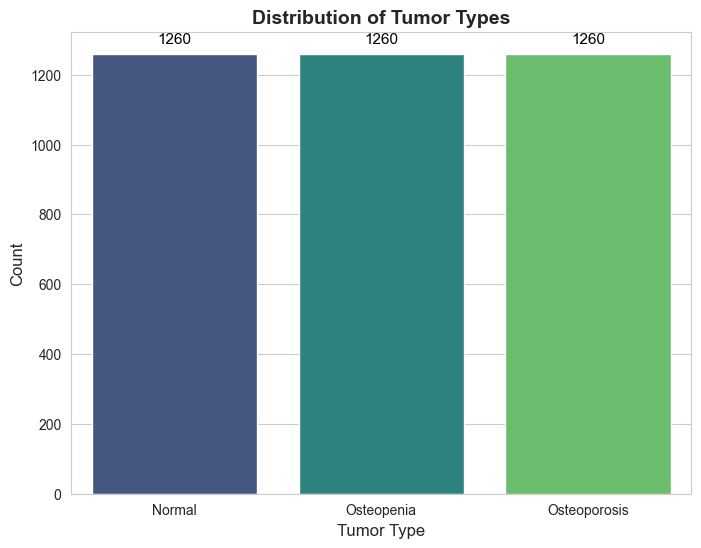

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)
ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=11, color='black',
        xytext=(0, 5), textcoords='offset points')

Text(0.5, 1.0, 'Distribution of Tumor Types - Pie Chart')

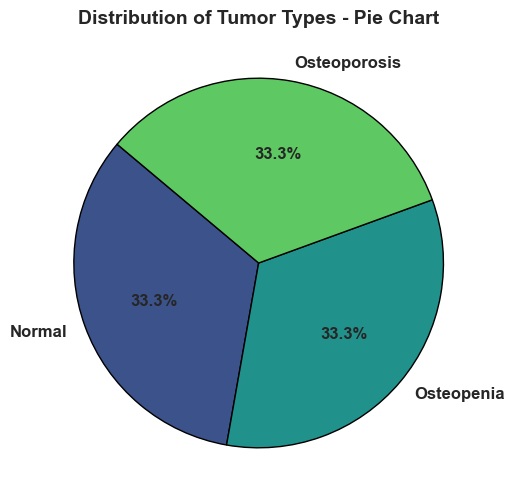

In [ ]:
label_counts = df["label"].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
startangle=140, colors=colors, textprops={'fontsize': 12, 'weight':
'bold'},
wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14,
fontweight='bold')

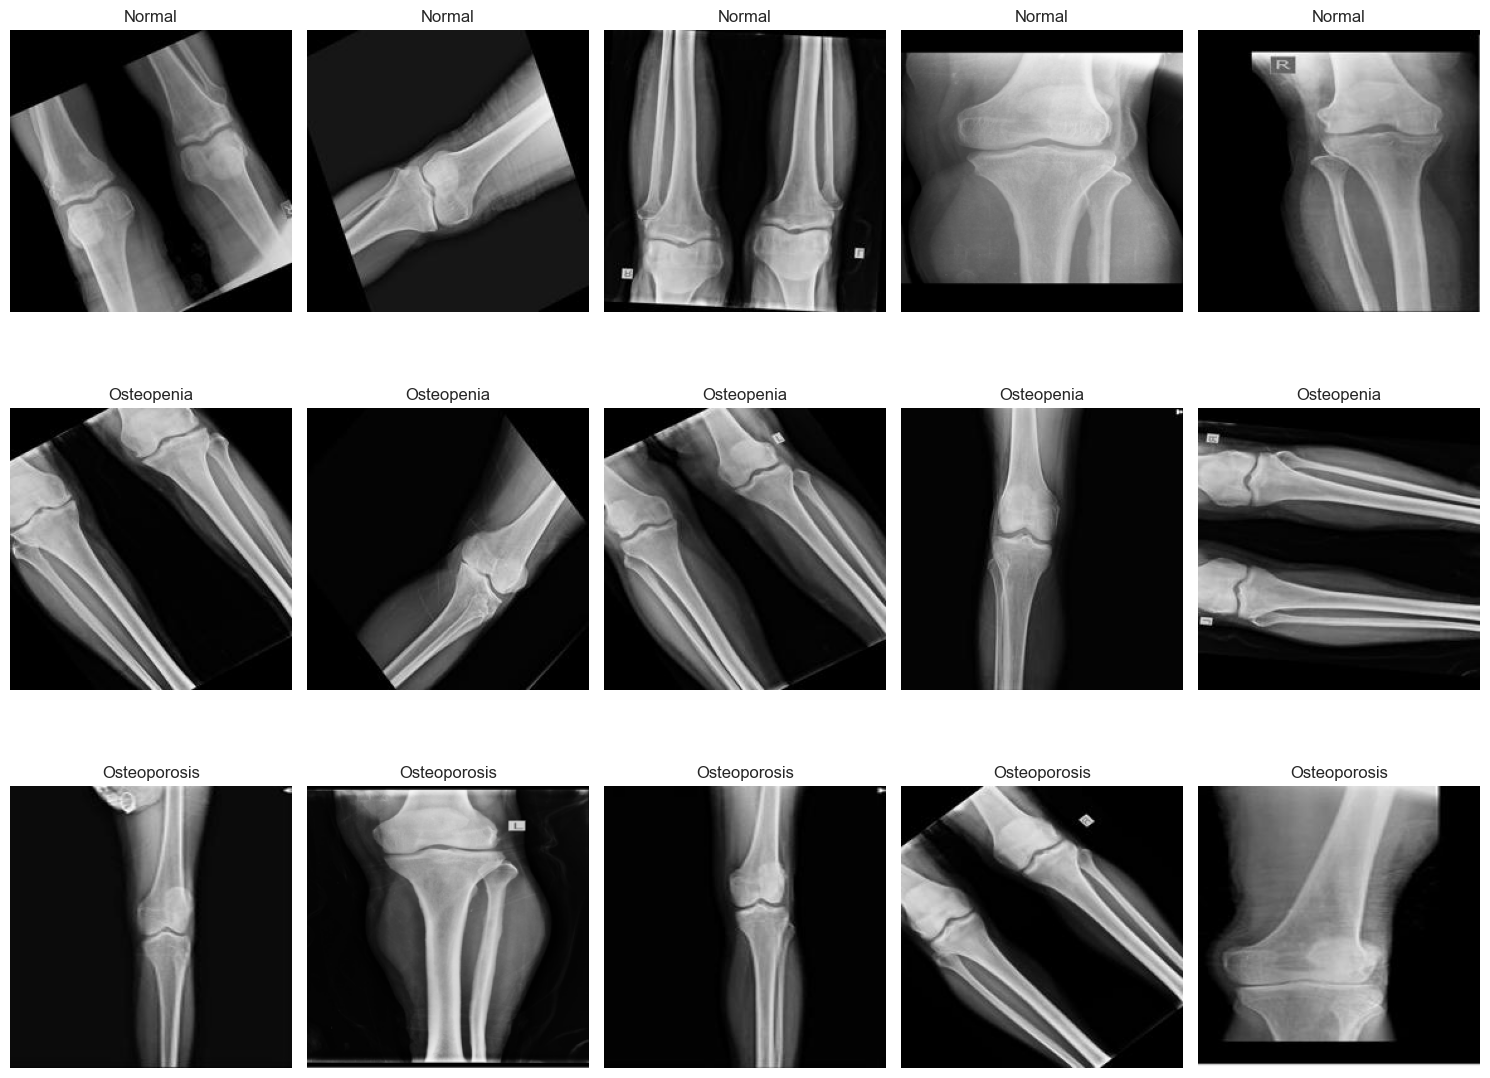

In [ ]:
num_images = 5
plt.figure(figsize=(15, 12))
for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]
    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show(block=False)
plt.pause(5)
plt.close()


In [ ]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])
df = df[['image_path', 'category_encoded']]

In [ ]:
train_df, temp_df = train_test_split(
df,
train_size=0.8,
shuffle=True,
random_state=42,
stratify=df['category_encoded']
)
print(train_df.shape)
print(temp_df.shape)

(3024, 2)
(756, 2)


In [ ]:
valid_df, test_df = train_test_split(
temp_df,
test_size=0.5,
shuffle=True,
random_state=42,
stratify=temp_df['category_encoded']
)
print(valid_df.shape)
print(test_df.shape)

(378, 2)
(378, 2)


In [ ]:
batch_size = 32 #16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [ ]:
trainDataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['category_encoded'].values))
validDataset = tf.data.Dataset.from_tensor_slices((valid_df['image_path'].values, valid_df['category_encoded'].values))
testDataset = tf.data.Dataset.from_tensor_slices((test_df['image_path'].values, test_df['category_encoded'].values))

2025-02-25 16:34:41.101117: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-25 16:34:41.101166: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-25 16:34:41.101173: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1740530081.101681 12268139 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740530081.101742 12268139 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
len(trainDataset), len(validDataset), len(testDataset)

(3024, 378, 378)

In [ ]:
for x, y in trainDataset.take(1):
    print(f"Image path: {x.numpy()}, Label: {y.numpy()}")

Image path: b'Dataset/train/Osteopenia/Osteopenia 240_aug_1.jpeg', Label: 1


2025-02-25 16:34:42.322196: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
len(trainDataset), len(validDataset), len(testDataset)

(3024, 378, 378)

In [ ]:
def processDataset(image_path, label):
    image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=channels)
    image = tf.image.resize(image, img_size)
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    label = tf.one_hot(tf.cast(label, tf.int32), depth=len(categories))
    return image, label

In [ ]:
trainDataset = trainDataset.map(processDataset, num_parallel_calls=tf.data.AUTOTUNE)
validDataset = validDataset.map(processDataset, num_parallel_calls=tf.data.AUTOTUNE)
testDataset = testDataset.map(processDataset, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
trainDataset.save('TfDatasets/trainDataset')
validDataset.save('TfDatasets/validDataset')
testDataset.save('TfDatasets/testDataset')

# IMPORT DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import time
import shutil
import pathlib
import itertools
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.metrics import Precision, Recall, AUC

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA

In [3]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [4]:
TfDatasetsPath = '/content/drive/MyDrive/CSEN-240-Project/TfDatasets'
# TfDatasetsPath = 'TfDatasets'

In [5]:
trainDataset = tf.data.Dataset.load(TfDatasetsPath + "/trainDataset")
validDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

In [8]:
def augment(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image - tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [9]:
augmentedDataset = trainDataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
trainDataset = trainDataset.concatenate(augmentedDataset)

In [11]:
len(trainDataset), len(validDataset), len(testDataset)

(6048, 378, 378)

In [12]:
trainDataset = trainDataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validDataset = validDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
trainDataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# XCEPTION MODEL

In [14]:
metrics = [Precision(), Recall(), AUC(), 'accuracy']

In [15]:
def create_xception_model(input_shape, num_classes=3, learning_rate=1e-4):
    inputs = tf.keras.layers.Input(shape=input_shape, name="Input_Layer")
    base_model = tf.keras.applications.Xception(weights="imagenet", input_tensor=inputs, include_top=False, name="Xception")
    base_model.trainable = True
    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    x = tf.keras.layers.Reshape((height * width, channels), name="Reshape_to_Sequence")(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=channels, name="Multi_Head_Attention")(x, x)
    x = tf.keras.layers.Reshape((height, width, channels), name="Reshape_to_Spatial")(x)
    x = tf.keras.layers.GaussianNoise(0.25, name="Gaussian_Noise")(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = tf.keras.layers.Dense(256, activation="relu", name="FC_256")(x)
    x = tf.keras.layers.BatchNormalization(name="Batch_Normalization")(x)
    x = tf.keras.layers.Dropout(0.5, name="Dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax",name="Output_Layer")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="Xception_with_Attention")
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
    return model

# TRAINING

In [16]:
input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape, num_classes=3, learning_rate=3e-4)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
cnn_model.summary()

Model: "Xception_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ Input_Layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 155,656,747 (593.78 MB)

 Trainable params: 155,601,707 (593.57 MB)

 Non-trainable params: 55,040 (215.00 KB)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

In [19]:
history = cnn_model.fit(trainDataset,
                        validation_data=validDataset,
                        epochs=250,
                        callbacks=[early_stopping],
                        verbose=1)

Epoch 1/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.5404 - auc: 0.7139 - loss: 1.0896 - precision: 0.5775 - recall: 0.4445 - val_accuracy: 0.3624 - val_auc: 0.6678 - val_loss: 1.2816 - val_precision: 0.3886 - val_recall: 0.3413
Epoch 2/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.7628 - auc: 0.9037 - loss: 0.6025 - precision: 0.7933 - recall: 0.7021 - val_accuracy: 0.4683 - val_auc: 0.7200 - val_loss: 1.0554 - val_precision: 0.5210 - val_recall: 0.4259
Epoch 3/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.8325 - auc: 0.9547 - loss: 0.4107 - precision: 0.8528 - recall: 0.8142 - val_accuracy: 0.5423 - val_auc: 0.7758 - val_loss: 1.1028 - val_precision: 0.5540 - val_recall: 0.5159
Epoch 4/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.8895 - auc: 0.9746 - loss: 0.3018 - precision: 0.9004 - recall: 0.8784 - val_accuracy: 0.6561 - val_auc: 0.8619 - val_loss: 0.8022 - val_precision: 0.6790 - val_recall: 0.6323
Epoch 5/250
95/95 ━━━━━━━━

# FINE-TUNING

In [ ]:
for layer in cnn_model.layers[1:-9]:
    layer.trainable = True

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=metrics)

In [ ]:
cnn_model.summary()

Model: "Xception_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ Input_Layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 156,183,083 (595.79 MB)

 Trainable params: 156,127,531 (595.58 MB)

 Non-trainable params: 55,552 (217.00 KB)

In [ ]:
history = cnn_model.fit( trainDataset,
                         validation_data=validDataset,
                         epochs=250,
                         callbacks=[early_stopping],
                         verbose=1)

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 92s 153ms/step - accuracy: 0.6037 - auc: 0.8097 - loss: 1.0167 - precision: 0.6734 - recall: 0.5586 - val_accuracy: 0.4180 - val_auc: 0.6534 - val_loss: 1.6146 - val_precision: 0.4294 - val_recall: 0.4101
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.7802 - auc: 0.9260 - loss: 0.5234 - precision: 0.8112 - recall: 0.7477 - val_accuracy: 0.5767 - val_auc: 0.7969 - val_loss: 0.9179 - val_precision: 0.5953 - val_recall: 0.5370
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.8758 - auc: 0.9700 - loss: 0.3305 - precision: 0.8867 - recall: 0.8627 - val_accuracy: 0.6587 - val_auc: 0.8513 - val_loss: 0.8272 - val_precision: 0.6734 - val_recall: 0.6217
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.9067 - auc: 0.9802 - loss: 0.2640 - precision: 0.9132 - recall: 0.8955 - val_accuracy: 0.7116 - val_auc: 0.8730 - val_loss: 0.8534 - val_precision: 0.7147 - val_recall: 0.6958
Epoch 5/250
189/

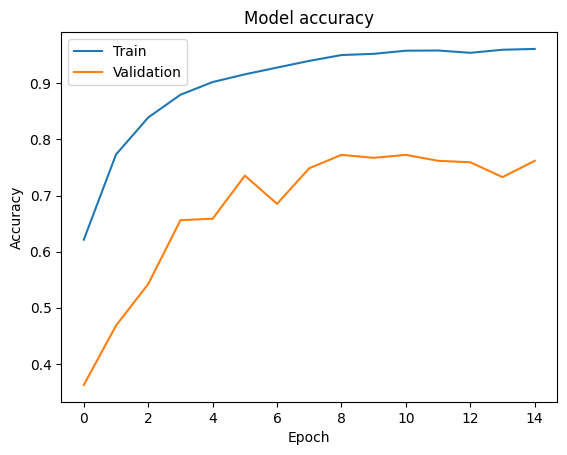

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

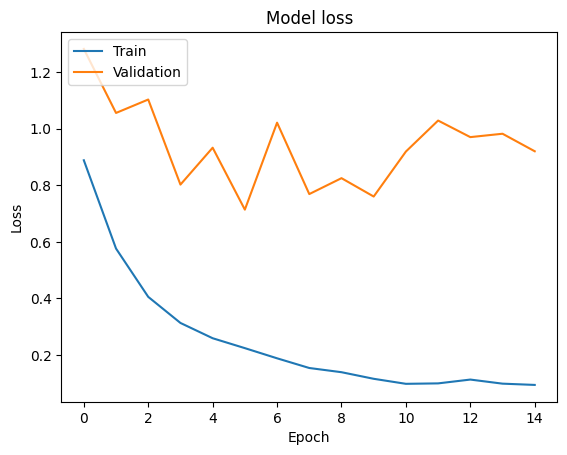

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [22]:
train_labels = []
for xBatch, yBatch in trainDataset:
    train_labels.extend(np.argmax(yBatch, axis=1))
predictions = cnn_model.predict(trainDataset)
predicted_classes = np.argmax(predictions, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step


In [23]:
len(predicted_classes), len(train_labels)

(6048, 6048)

In [24]:
report = classification_report(train_labels, predicted_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      Normal       0.32      0.34      0.33      2016
  Osteopenia       0.34      0.33      0.34      2016
Osteoporosis       0.34      0.33      0.34      2016

    accuracy                           0.33      6048
   macro avg       0.33      0.33      0.33      6048
weighted avg       0.33      0.33      0.33      6048



In [25]:
valid_labels = []
for xBatch, yBatch in validDataset:
    valid_labels.extend(np.argmax(yBatch, axis=1))
predictions = cnn_model.predict(validDataset)
predicted_classes = np.argmax(predictions, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step


In [26]:
report = classification_report(valid_labels, predicted_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      Normal       0.79      0.84      0.82       126
  Osteopenia       0.74      0.75      0.75       126
Osteoporosis       0.77      0.71      0.74       126

    accuracy                           0.77       378
   macro avg       0.77      0.77      0.77       378
weighted avg       0.77      0.77      0.77       378



In [27]:
def ppo_loss(y_true, y_pred):
    epsilon = 0.2
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    selected_probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
    old_selected_probs = tf.reduce_sum(tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1)
    ratio = selected_probs / (old_selected_probs + 1e-10)
    clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(ratio, clipped_ratio))
    return loss

In [28]:
ppo_loss_value = ppo_loss(valid_labels, predictions)
print("\nPPO Loss on Validation Data:", ppo_loss_value.numpy())


PPO Loss on Validation Data: -1.0


# TESTING

In [29]:
test_labels = []
for xBatch, yBatch in testDataset:
    test_labels.extend(np.argmax(yBatch, axis=1))
predictions = cnn_model.predict(testDataset)
predicted_classes = np.argmax(predictions, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [30]:
report = classification_report(test_labels, predicted_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      Normal       0.77      0.89      0.82       126
  Osteopenia       0.78      0.76      0.77       126
Osteoporosis       0.82      0.71      0.76       126

    accuracy                           0.79       378
   macro avg       0.79      0.79      0.78       378
weighted avg       0.79      0.79      0.78       378



Text(95.72222222222221, 0.5, 'True Label')

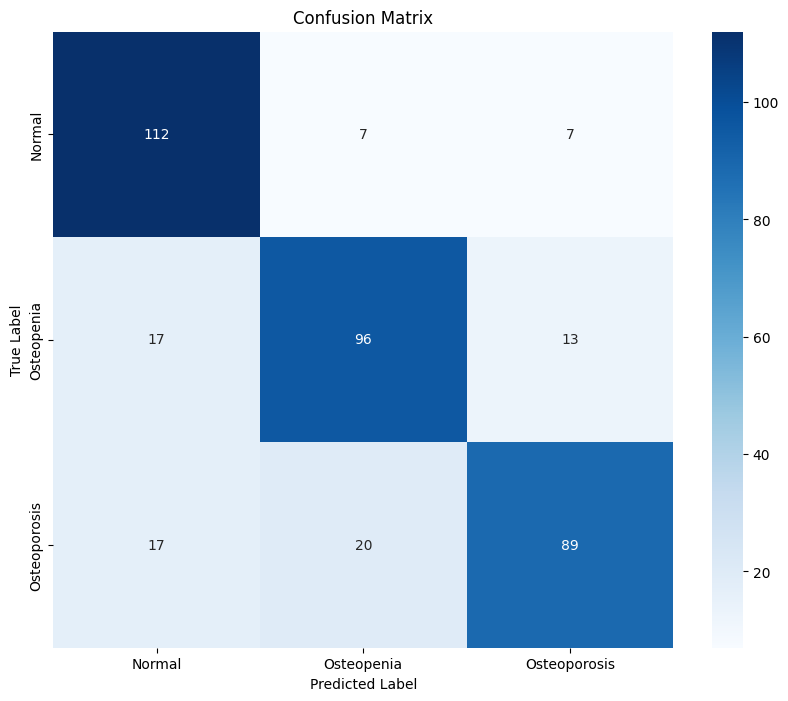

In [31]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')